# Photon Counting SPIFI Principles & Example Code
## About
Author: Daniel Scarbrough

Date: May 23, 2024

---

This notebook demonstrates a simple SPIFI imaging simulation in Python, with simulated photon detection probabilities along with a laser repetition rate to show how photon counting is necessary to build-up a SPIFI signal over time in low-signal-light environments. Photon counting SPIFI enables viable images out to a fourth-order enhancement in two-photon modalities due to the increased overall exposure time and greater dynamic range of the counted signal.

Please note that this notebook is intended to demonstrate the principles of photon counting SPIFI only, and does not represent a full simulation that takes all real-world factors, such as positioning of individual emitters, bleaching, etc. into account.

## Packages and Definitions

Below are the required package imports, as well as a check for the 
versions used in production of this notebook. If you are running this notebook 
yourself and are having issues, check your versions listed from the code cell 
below and look for any 
deprecation errors, missing features, etc. The versions of Python, NumPy, 
SciPy, and Matplotlib used are as follows:

Python Version: 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]

Numpy Version: 1.24.2

Scipy Version: 1.10.1

Matplotlib Version: 3.7.1

It is often recommended to run Python in a virtual environment. A tutorial on how to do so can be found here:
https://docs.python.org/3/tutorial/venv.html

In [29]:
# print the Python version
import sys
print("Python Version:", sys.version)

# print the Numpy version
import numpy as np
print("Numpy Version:", np.__version__)

# print the Scipy version
import scipy as sp
print("Scipy Version:", sp.__version__)
from scipy.signal import find_peaks

# print the Matplotlib version
import matplotlib as mpl
import matplotlib.pyplot as plt
print("Matplotlib Version:", mpl.__version__)

# extra matplotlib import for multiple plots in one figure
from matplotlib.gridspec import GridSpec

Python Version: 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
Numpy Version: 1.24.2
Scipy Version: 1.10.1
Matplotlib Version: 3.7.1


In [30]:
# Define units for convenience
# distance units
mm = 10**-3
um = 10**-6

# time units
ms = 10**-3
us = 10**-6

# temporal frequency units
kHz = 10**3
MHz = 10**6

We define some helper functions for use throughout the notebook. These include
a one-dimensional Fast Fourier Transform (FFT) with appropriate shifting; a 
Gaussian function that takes a grid, a center value, a width, and an optional 
amplitude to produce a Gaussian profile; and a helper function to find the 
index of an array 'x' that most closely matches a value to find 'xf'.

In [31]:
# 1D FFT
def fft1(data, axis=0):
    return np.fft.fftshift(
        np.fft.fft(
            np.fft.ifftshift(
                data, axes=axis
            ), axis=axis
        ), axes=axis
    )

# Gaussian function
def gauss(x, x0, w, a=1):
    return a * np.exp(-(x-x0)**2 / (2*w**2))

# Finds the nearest index in x corresponding to value xf
def find_nearest_idx(x, xf):
    return int(np.rint(np.argmin(np.abs(x - xf))))

## Simulating SPIFI
### Mask generation
The following function takes a 2D mesh grid for x and y (see NumPy meshgrid: [https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)), along with relevant SPIFI parameters to produce a 2D binary SPIFI mask for simulation. In this case, the mask is in a Cartesian form as is used in polygonal scan mirror implementations of SPIFI. 

In [32]:
# boolean cartesian SPIFI mask generator
def SPIFI_mask_cart(
    xGrid, yGrid, k, y0, dutyCycle=0.5
):
    xMax = np.max(xGrid)
    maskBool = np.zeros(np.shape(xGrid), dtype=bool)
    mask = 0.5 + 0.5 * \
        np.cos(k * (y0 + yGrid) * (np.pi * xGrid / xMax))
    mask[mask > 1 - dutyCycle] = 1
    mask[mask <= 1 - dutyCycle] = 0
    maskBool[:, :] = np.copy(mask)
    
    mask = None
    del mask

    return maskBool

The mask parameters can then be set, such as: simulation resolution (`NN` x `MM`), spatial frequency parameters (`k` and `y0`), and dimensions (`xDim` and `yDim`). An array (or grid) is defined for each dimension, x and y (`xArr` and `yArr`), to define the spatial coordinates along the desired number of points `NN` and `MM`. 

Note that Python follows "row major order", meaning the first axis of a 2D array is the rows, while the second axis is the columns. For a 2D x and y coordinate grid `xy`, accessing an element as `xy[a, b]` selects the y coordinate corresponding to the `a` index of the rows and the x coordinate corresponding to the `b` index of the columns.

A meshgrid is then defined using both the x and y arrays. The meshgrid produces two 2D arrays, one holding a 2D grid of x coordinates and the other a 2D grid of y coordinates. This is useful because if given any pair of indices to access a specific row and element of the array, that coordinate pair can be used to access both the x and y values. The two tables included in the GitHub directory `img/xmesh_table.png` and `img/ymesh_table.png` show an example of meshgrid indices and coordinates for an XY coordinate plane.

Meshgrids are also useful in Python because they can be fed to a function that is dependent on x and y and the result will be calculated by automatically taking the x and y values at each matching coordinate.

Note: If the following cell takes too long to execute or takes too much memory on your machine, reduce MM. Commenting out the plot will also speed up the execution as it will not have to render the mask image.

In [33]:
# Number of points on each axis
NN = 2048
MM = 50000

# SPIFI mask parameters
k = 10/mm  # chirp rate
y0 = 7*mm # offset

# dimensions (size) of SPIFI mask
xDim = 14*mm
yDim = 5*mm

# Arrays of positions
xArr = np.linspace(-xDim/2, xDim/2, num=MM)
yArr = np.linspace(0.0, yDim, num=NN)

# meshgrid of positions for SPIFI mask
xGrid, yGrid = np.meshgrid(xArr, yArr)

With the necessary variables defined, a SPIFI mask can be generated for simulation. For this simple simulation, the SPIFI mask is produced with a duty cycle <50%. In a simulation such as this, a 50% duty cycle mask would not yield even order SPIFI images (2nd, 4th, etc.) as a square wave only yields odd harmonics following an FFT.

Also worth noting here is the use of `imshow` instead of `pcolormesh`. `pcolormesh` produces an image from the image data as well as the x and y meshgrid to accurately space the pixels at the cost of greater computation time. Because the x and y meshgrids are evenly spaced in this case, this is not necessary and `imshow` renders and accurate image with much less time. 

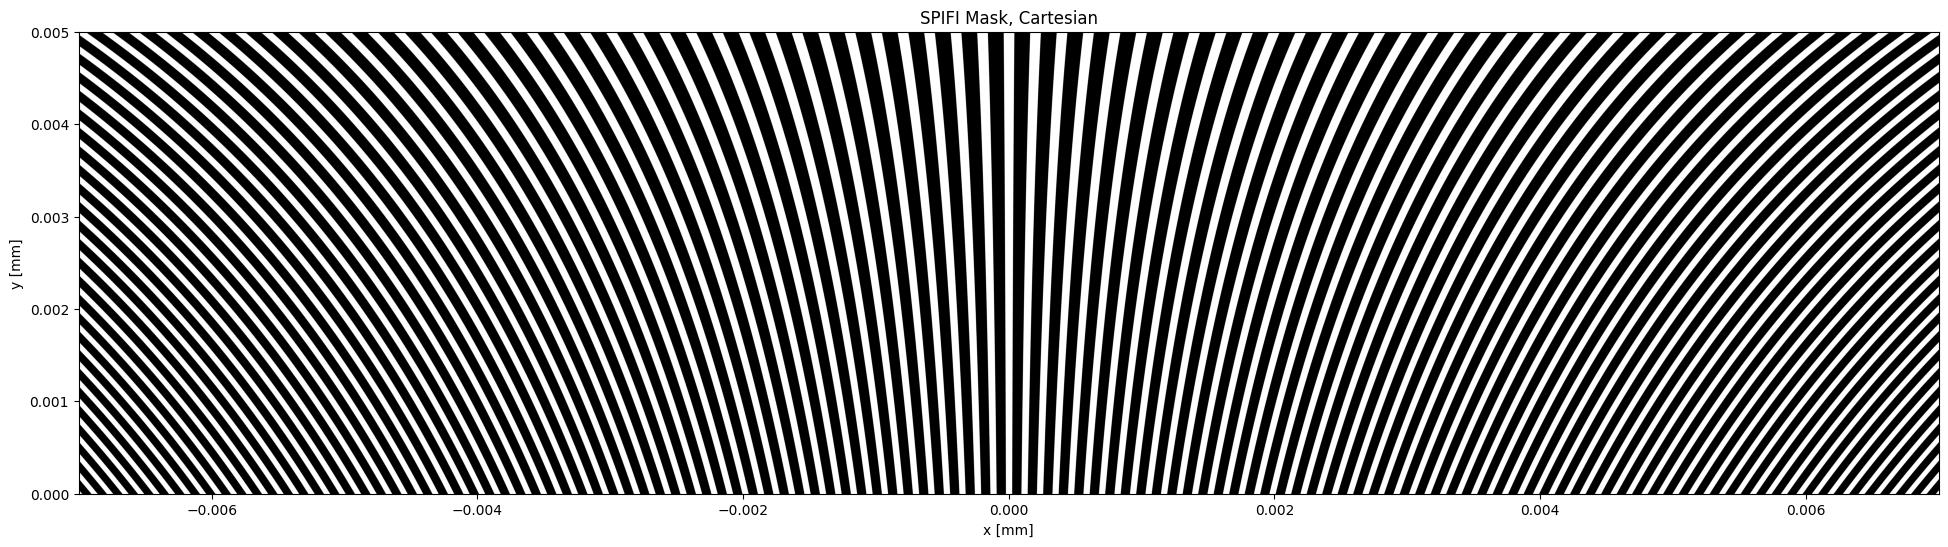

In [34]:
# Generate the mask with a lower duty cycle
mask = SPIFI_mask_cart(xGrid, yGrid, k, y0, dutyCycle=0.35)

# plot the mask. Note aliasing is likely on display
plt.figure(figsize=(24,6))
plt.imshow(
    mask, cmap='gray', aspect='auto', extent=[xArr[0], xArr[-1], yArr[0], yArr[-1]]
)
plt.title("SPIFI Mask, Cartesian")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.show()

### Beam modulation
Next, we want to simulate the excitation beam. For simplicity, we will simulate the beam modulation with the mask with a strictly 1D Gaussian beam.

When multiplying a 1D array by a 2D array, Numpy will check the sizes of the arrays. If the 1D array is the same length as each row (or in this case the same length of the x grid) then the multiplication will be applied row by row. If not, a broadcasting error will be thrown. In this case, we want the beam profile to be multiplied across each column, as the beam will project along y and scan across x. To do this, in Python we can use a "dummy" axis to explicitly indicate how the multiplication should be performed. 

The line `beam_mod = mask * beam_prof[:, None]` uses the keyword `None` to define the dummy axis. The beam profile is then oriented across the rows (in y) to multiply across the rows of the `mask` array.

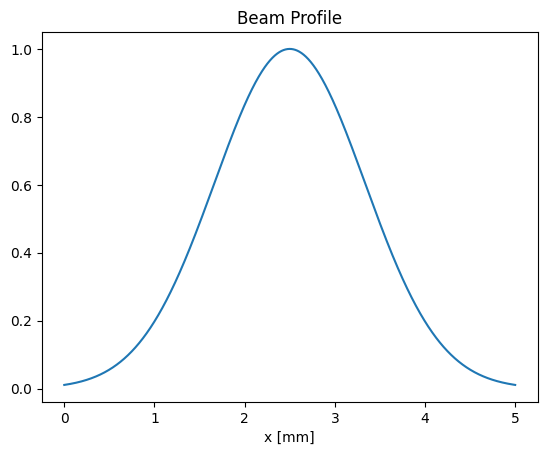

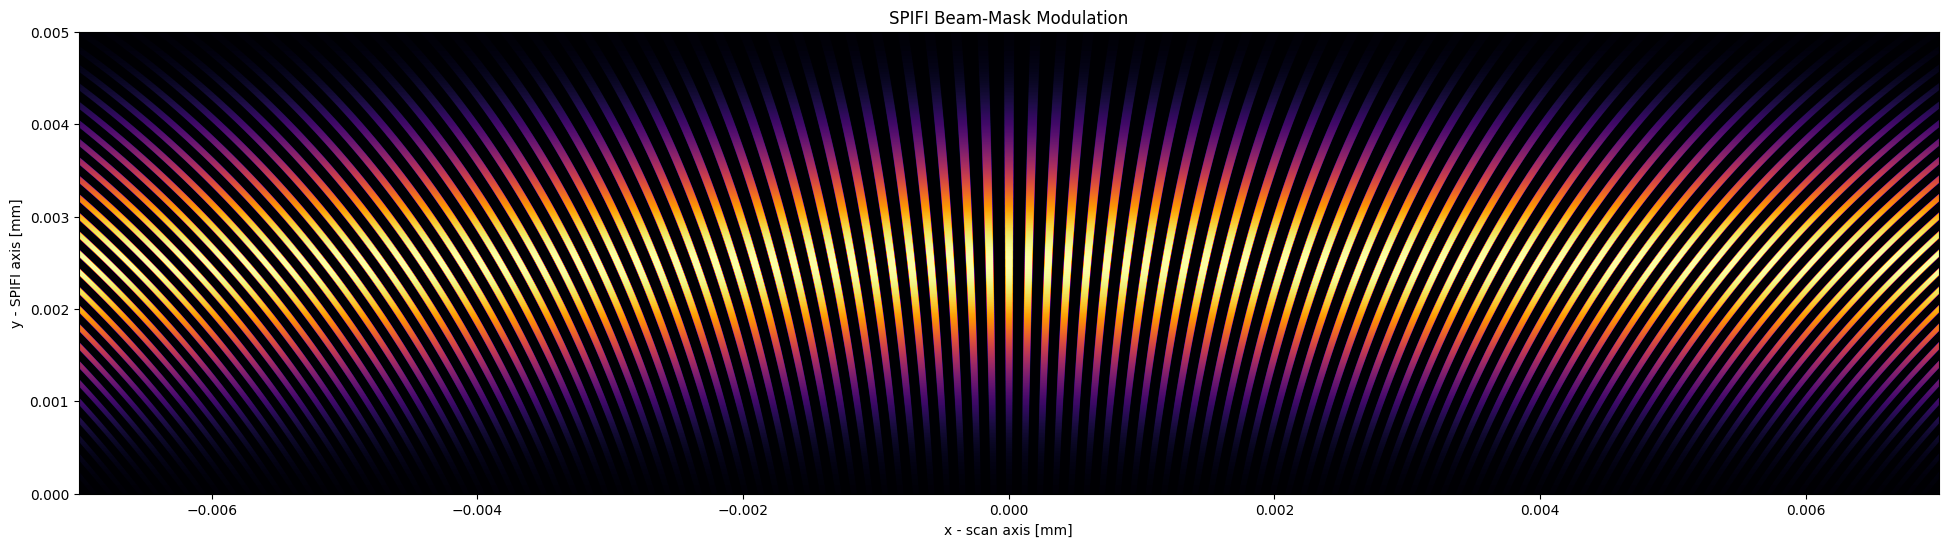

In [35]:
# Simulate the Gaussian beam profile
beam_yc = yDim / 2
beam_w = yDim / 6
beam_prof = gauss(yArr, beam_yc, beam_w)

# Plot the beam profile
plt.plot(yArr/mm, beam_prof)
plt.title("Beam Profile")
plt.xlabel("x [mm]")
plt.show()

# Modulate the beam by the mask on axis 0, use 'None' for dummy axis
beam_mod = mask * beam_prof[:, None]

# Plot the beam-mask product
plt.figure(figsize=(24,6))
plt.imshow(
    beam_mod, cmap='inferno', aspect='auto', extent=[xArr[0], xArr[-1], yArr[0], yArr[-1]]
)
plt.title("SPIFI Beam-Mask Modulation")
plt.xlabel("x - scan axis [mm]")
plt.ylabel("y - SPIFI axis [mm]")
plt.show()

A 1D spatial frequency target is generated by the following function using the x coordinate array and a desired spatial frequency. For simplicity, this will be a binary on/off pattern.

In [36]:
def spatial_frequency_target(xArray, fx):
    MM = len(xArray)

    target = 0.5 + 0.5 * np.sign(
        np.cos(2*np.pi * fx * xArray - np.pi)
    )

    return target

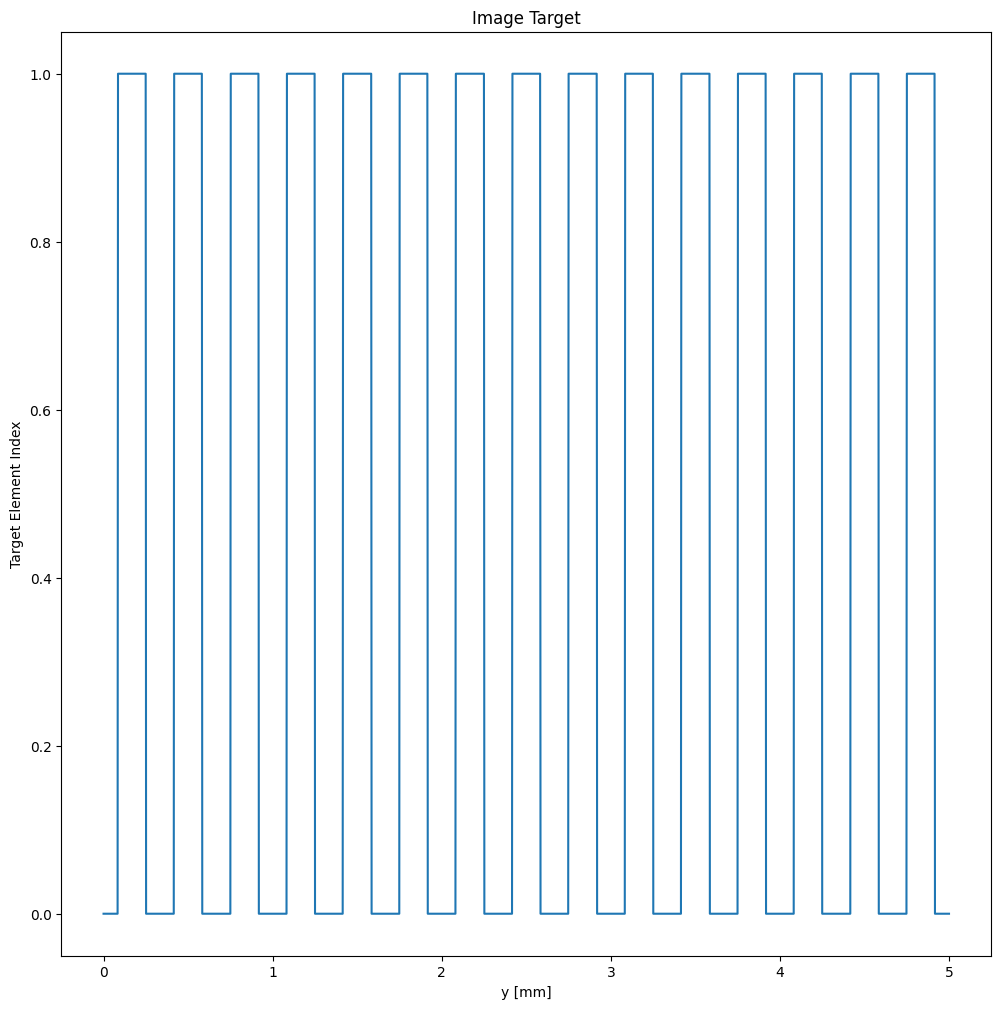

In [37]:
# Define a spatial frequency to image
fy = 3.0/mm

# generate the target
target = spatial_frequency_target(yArr, fy)

# plot the target
plt.figure(figsize=(12,12))
plt.plot(yArr/mm, target)
plt.title("Image Target")
plt.xlabel("y [mm]")
plt.ylabel("Target Element Index")
plt.show()

### Signal Simulation
The mask modulated beam product is then multiplied by the target across the y axis. For each step of the SPIFI mask modulation, the modulated beam is imaged to one 1D line to image on the target.

For linear imaging modalities, the square is taken to simulate detecting the intensity of the light. For a two-photon process, the 4th power is taken (square of the intensity). The sum is also taken here to simulate spatially integrating the light onto a single element detector to produce a voltage vs time signal in the case of a photodiode. Note that the `sum` function is performed along axis zero, which is the y axis and corresponds to the axis the line beam is projected along.

In [38]:
# initialize array and multiply modulated beam by object
beam_mod_target = np.zeros((NN, MM))
beam_mod_target[:, :] = beam_mod[:, :] * target[:, None]

# spatially integrate and square for intensity, square again for two-photon
target_signal = np.sum(beam_mod_target**4, axis=0)

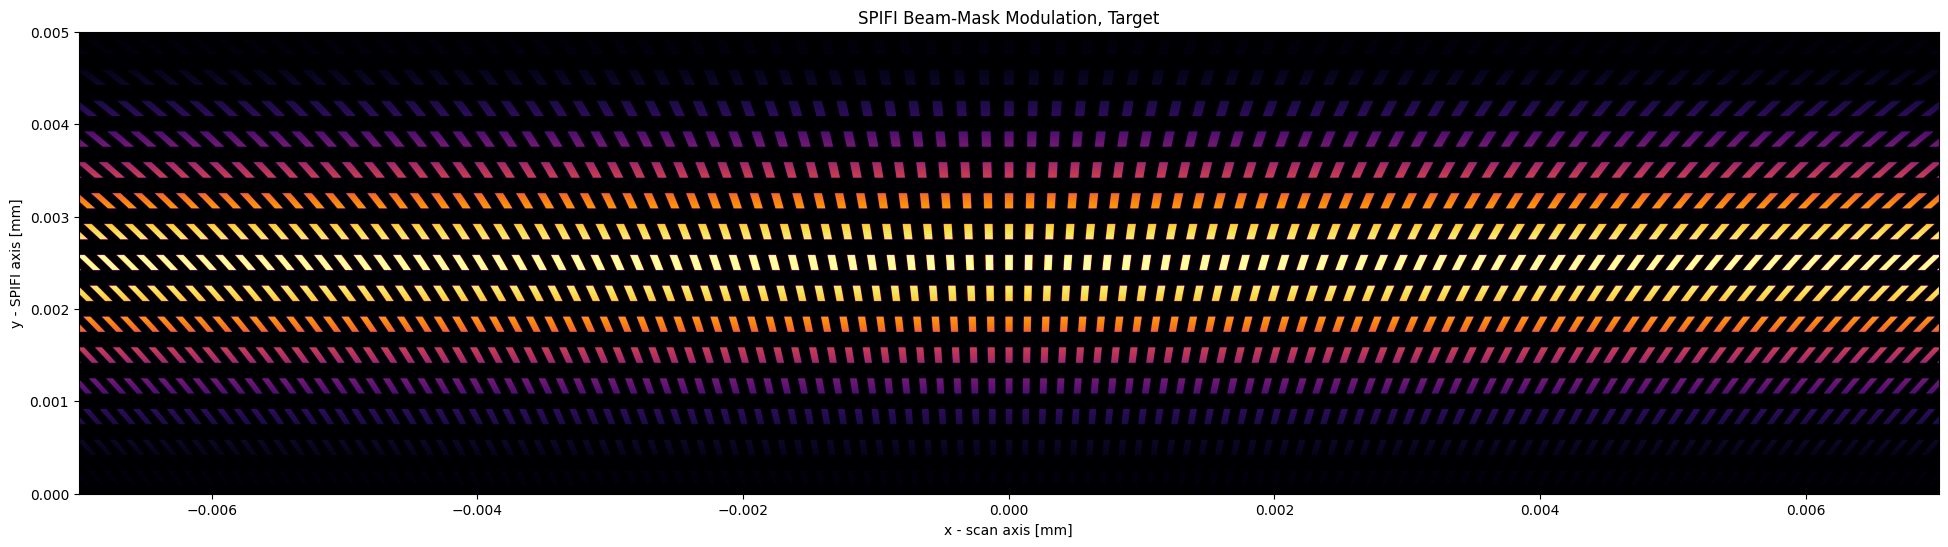

In [39]:
# plot the beam-modulated target (this is prior to the spatial integration)
plt.figure(figsize=(24,6))
plt.imshow(
    beam_mod_target, cmap='inferno', aspect='auto', extent=[xArr[0], xArr[-1], yArr[0], yArr[-1]]
)
plt.title("SPIFI Beam-Mask Modulation, Target")
plt.xlabel("x - scan axis [mm]")
plt.ylabel("y - SPIFI axis [mm]")
plt.show()

Simulated acquisition frequency: 100000.0 kHz


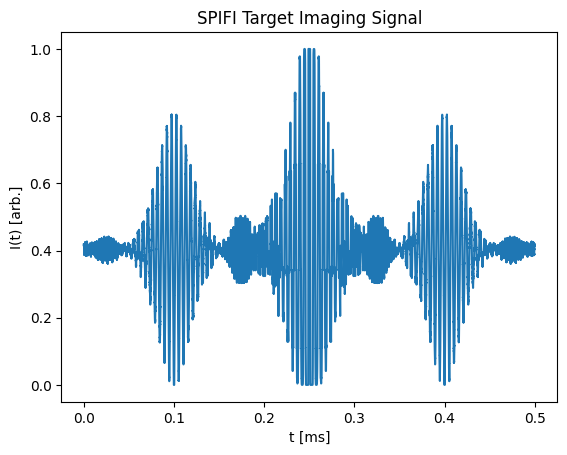

In [40]:
# Define the modulation period
freq = 100.0 * MHz
# Make a time array based on modulation period and number of scan steps
dt = 1 / freq # time step dependent on step number MM
tArr = np.arange(MM) * dt
print("Simulated acquisition frequency: {:.1f} kHz".format(1/dt/kHz))

# look at one scan signal from the target
plt.plot(tArr/ms, target_signal/np.max(target_signal))
plt.title("SPIFI Target Imaging Signal")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

## Photon Counting Regimes
### Laser Repetition Rate
This simulates a strong SPIFI signal that is acquirable via a photodiode. However, in a two-photon modality, it is likely that the signal light will be weak enough to require a photomultiplier tube (PMT). While possible to generate SPIFI images from raw PMT signals ([https://doi.org/10.1117/1.JBO.28.10.106502](https://doi.org/10.1117/1.JBO.28.10.106502)), the implementation of photon counting can be used to add up multiple exposures to increase SPIFI modulation contrast by effectively increasing the dynamic range according to the number of scans to acquire for counting.

To start simulating this, we can define the repetition rate of the laser being used for excitation. Then, a binary mask can be generated to indicate when during the scan time an excitation pulse arrived. In this case, the "mask" is used to define an array of true/false values to effectively filter the full time signal. 

An important piece of syntax to know here is on the line containing `laserRepMask[0::int(laserPeriod/dt)] = True`. In Python, arrays can be accessed via indices given with the square brackets `[]`. For a 1D array, a single index can be given to retrieve the value: `array1D[24]`, or by using the slice operator `:` to retrieve a range of values: `array1D[24:42]`, retrieving indices 24 through 42 non-inclusive. 2D arrays are indexed the same way, separating axis indices with a comma, and each axis can be accessed singly or with a slice: `array2D[2, 4]` or `array2D[2, 24:42]` or `array2D[24:42, 100:142]`. If all indices from a specified starting point through the end of the array are desired, the syntax is: `array1D[10:]`. Instead if the whole array up to an index is desired, then `array1D[:10]` does this.

An additional feature of slicing is specifying a step size. For example the following: `array1D[3:11:2]` will retrieve all values from indices 3 to 11 (exclusive) in steps of 2. So the result would be the values stored at indices 3, 5, 7, and 9. If it is desired to pull out indices through the end of the array in a step size, no end value is given. For example `array1D[10::3]` would start at index 10 and pull out every 3rd value through the end of the array. This is how the line `laserRepMask[0::int(laserPeriod/dt)] = True` is working. It takes the first (zeroth) index and every index corresponding to the laser period time and sets it to true.

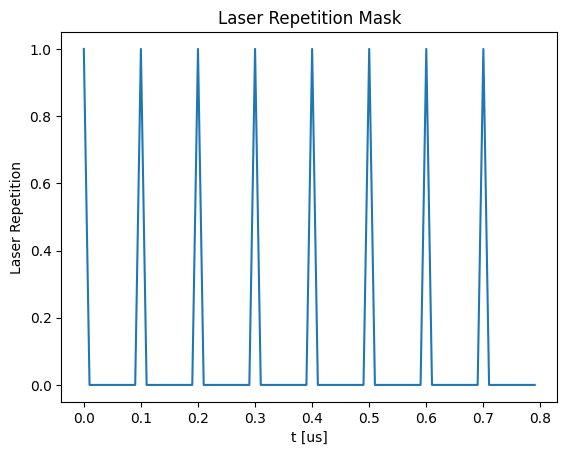

In [41]:
# make an array of a comb of zeros and ones with ones at a given interval
laserRepMask = np.zeros(MM, dtype=bool)
laserPeriod = 0.1e-6
# The following sets the mask to true starting from index 0 and over every step
# of the laser period, defined by the index step size from int(laserPeriod/dt)
laserRepMask[0::int(laserPeriod/dt)] = True

# plot the laser repetition mask
plt.plot(tArr[0:80]/us, laserRepMask[0:80])
plt.title("Laser Repetition Mask")
plt.xlabel("t [us]")
plt.ylabel("Laser Repetition")
plt.show()

We can then multiply the laser repetition mask by the SPIFI signal to filter out all parts of the signal that do not coincide with an excitation pulse. Minus noise, we would not detect a signal photon when there is not an excitation pulse incident on the sample.

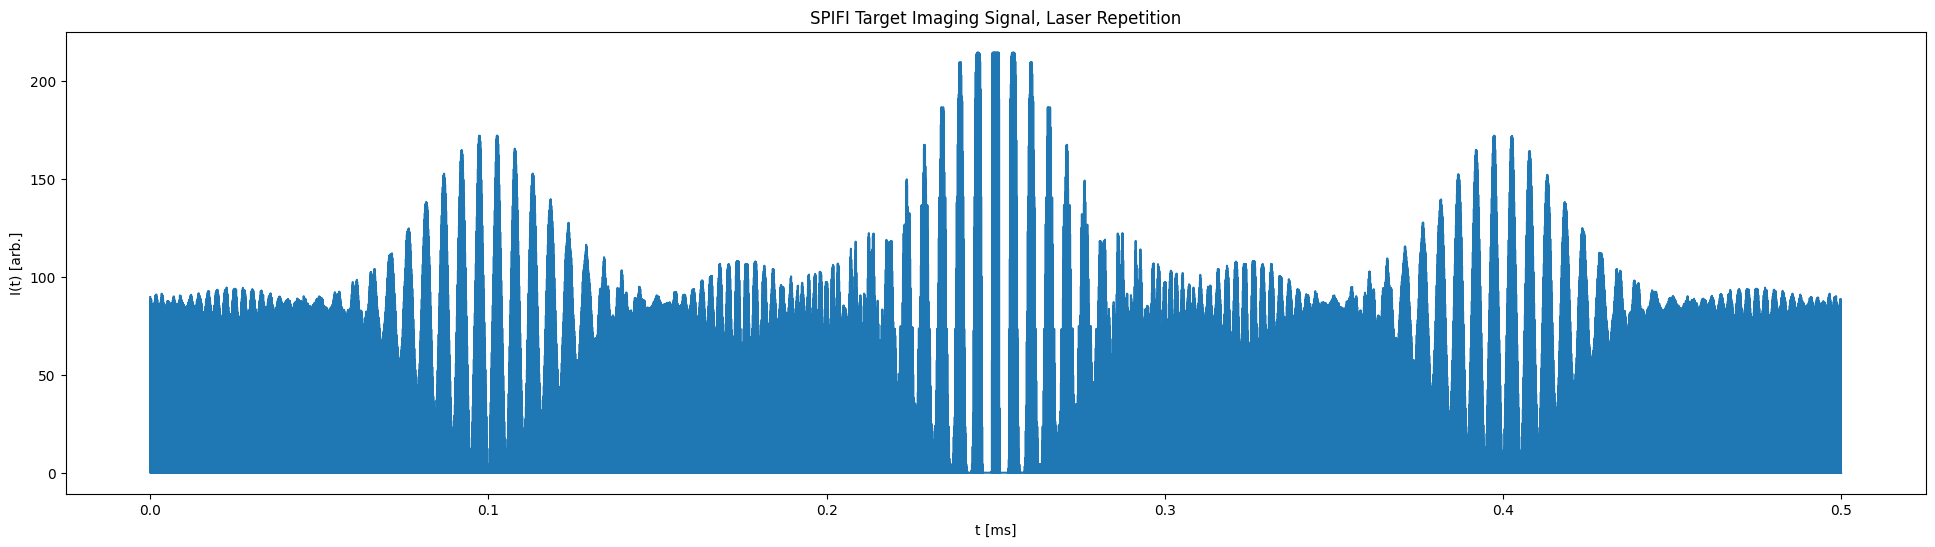

In [42]:
target_signal_rep = target_signal * laserRepMask

# plot the target signal with laser repetition
plt.figure(figsize=(24,6))
plt.plot(tArr/ms, target_signal_rep)
plt.title("SPIFI Target Imaging Signal, Laser Repetition")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

### Photon Detection Efficiency
The result is the SPIFI intensity signal with all values outside of an excitation pulse set to zero. To turn this into a photon counting simulation, this is normalized and multiplied by an efficiency to produce an array of probabilities for detecting a photon at each time step. Then at each time step, a random number is selected and compared to the probability. If it falls within the probability range, then a photon is detected and the counter for that time step (time bin) is incremented by one.

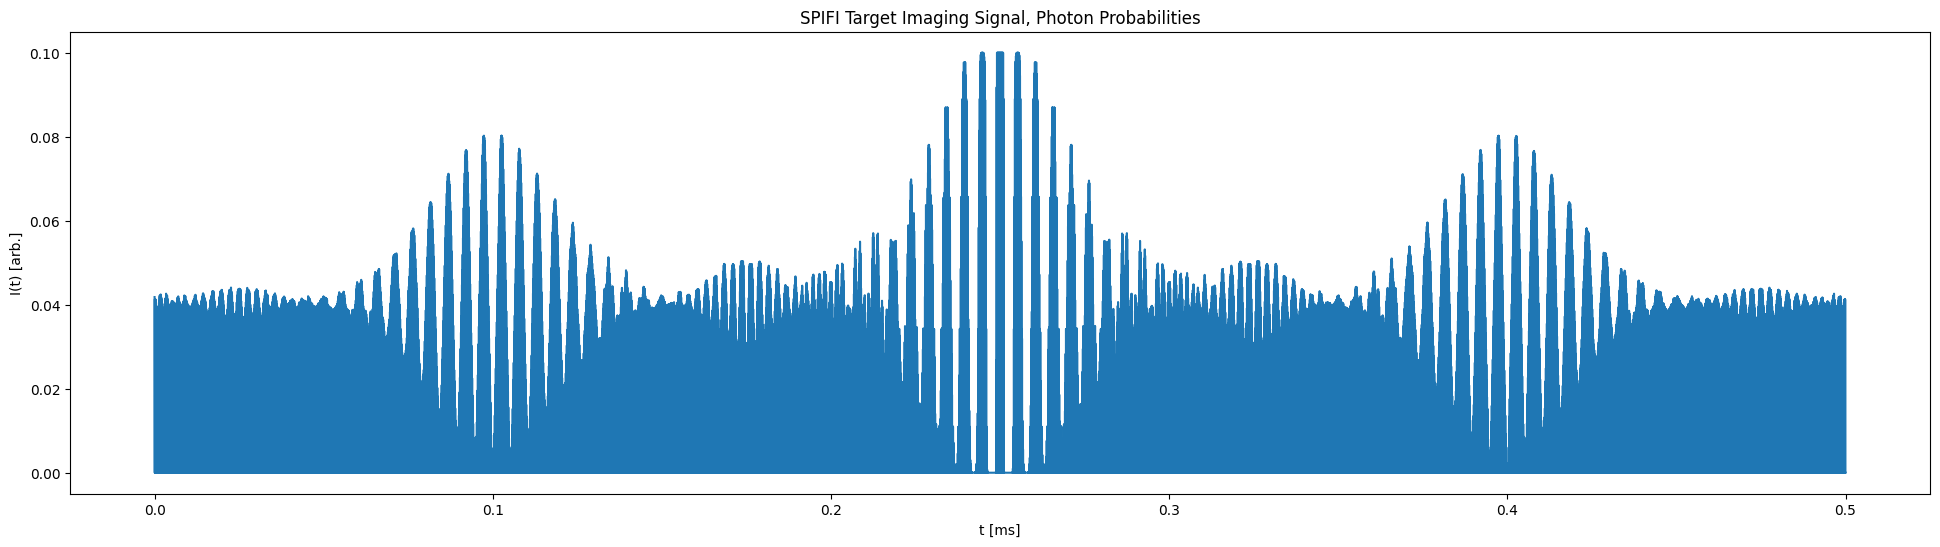

In [43]:
# emission and detection efficiency
efficiency = 0.1

# Normalize the target signal and multiply by the efficiency to simulate a 
# probability of a photon emission and detection at any given SPIFI step.
photonProbabilities = target_signal_rep / np.max(target_signal_rep) * efficiency

# plot the photon probabilities
plt.figure(figsize=(24,6))
plt.plot(tArr/ms, photonProbabilities)
plt.title("SPIFI Target Imaging Signal, Photon Probabilities")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

The following function handles the random number generation and checking against the photon detection probabilities to simulate signal photons. Of note in this is the syntax: `signal[randArr < probabilities] = -0.4`. This syntax works much like the true/false mask used to filter the SPIFI signal against the laser repetion rate. For each index of `signal` where `randArr < probabilities` is true, then the assignment `= -0.4` is applied. This is a feature of NumPy arrays known as boolean indexing.

In [44]:
def simulate_signal(probabilities, amplitudeNoise):
    signal = np.zeros(MM)
    randArr = np.random.rand(MM)
    # array of random numbers from -1 to 1, scaled by amplitudeNoise
    noiseArr = amplitudeNoise * (2 * np.random.rand(MM) - 1)
    signal[randArr < probabilities] = -0.4
    signal[randArr < probabilities] += noiseArr[randArr < probabilities]

    return signal

With the probabilities and the function to randomly produce a PMT signal set, the PMT signal for one full SPIFI modulation period can be simulated:

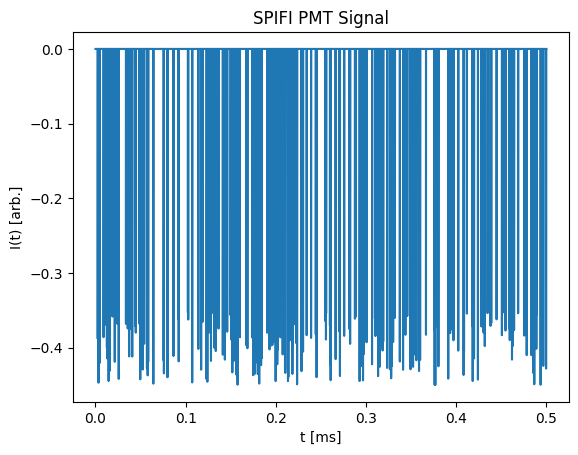

In [45]:
plt.plot(tArr/ms, simulate_signal(photonProbabilities, 0.05))
plt.title("SPIFI PMT Signal")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

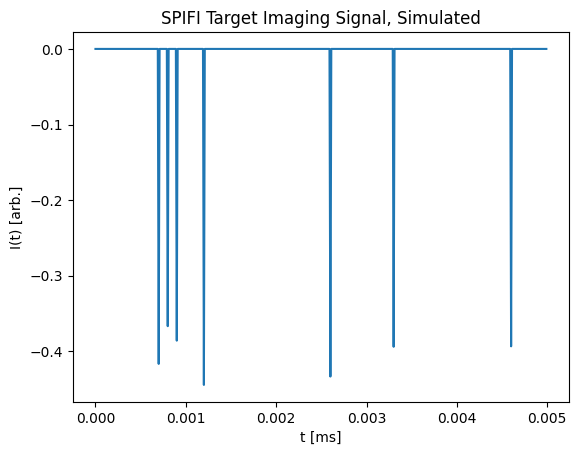

In [46]:
plt.plot(tArr[:500]/ms, simulate_signal(photonProbabilities*4, 0.05)[:500])
plt.title("SPIFI Target Imaging Signal, Simulated")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

We can look at a number of simulated signals closely to see what is happening during counting very clearly.

In [47]:
# Simulate some signals for closer examination
simulatedSignals = []
for _ in range(5):
    simulatedSignals.append(simulate_signal(photonProbabilities*8, 0.05))
    simulatedSignals[-1][0] = 0.0

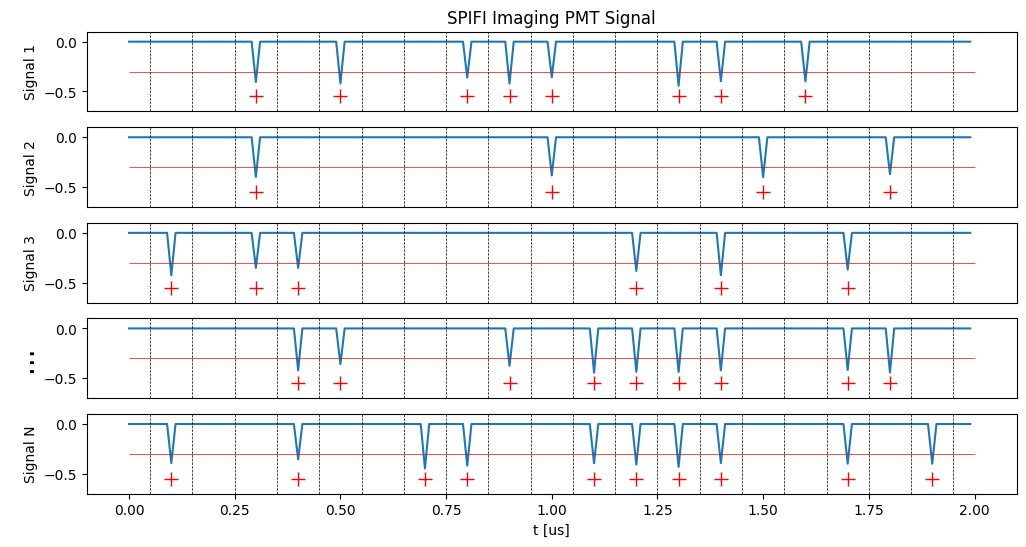

In [48]:
# Plot these simulated signals close up to get a better look
# We will also look at a threshold to determine the presence of signal photons
fig = plt.figure(figsize=(12,6))
gs = GridSpec(5, 1, figure=fig)
focusTime = 2e-6
focusIdx = find_nearest_idx(tArr, focusTime)
repTime = 0.1e-6
for ii in range(5):
    plt.subplot(5, 1, ii+1)
    plt.plot(tArr[:focusIdx]/us, simulatedSignals[ii][:focusIdx])
    # find the peaks in the signal
    peaks, _ = find_peaks(np.abs(simulatedSignals[ii][:focusIdx]))
    plt.plot(tArr[peaks]/us, [-0.55]*len(peaks), '+', markersize=10, color='r')
    plt.ylim(-0.7, 0.1)
    # Plot the threshold for counting
    plt.hlines(-0.3, 0, focusTime/us, color='r', linestyle='-', linewidth=0.5)
    # draw a vertical line every 100 ns for the repetition rate
    if ii < 3:
        plt.ylabel("Signal {}".format(ii+1))
    elif ii == 3:
        plt.ylabel("...", fontsize=20)
    else:
        plt.ylabel("Signal N")
    for jj in range(int(focusTime/repTime)):
        plt.vlines((jj*repTime + (repTime/2))/us, -0.7, 0.1, color='k', linestyle='--', linewidth=0.5)
    if ii == 0:
        plt.title("SPIFI Imaging PMT Signal")
    if ii != 4:
        plt.xticks([])
    else:
        plt.xlabel("t [us]")
plt.show()

The principles of counting photons to produce a quasi-analog SPIFI signal from signals such as these is to increment and integer counter for each time bin when a signal is present that crosses the threshold, indicated by the red plus marks above. The time bins are the same for every signal, so that over many acquisitions the counters continue to increment up to a desired number of acquisitions.

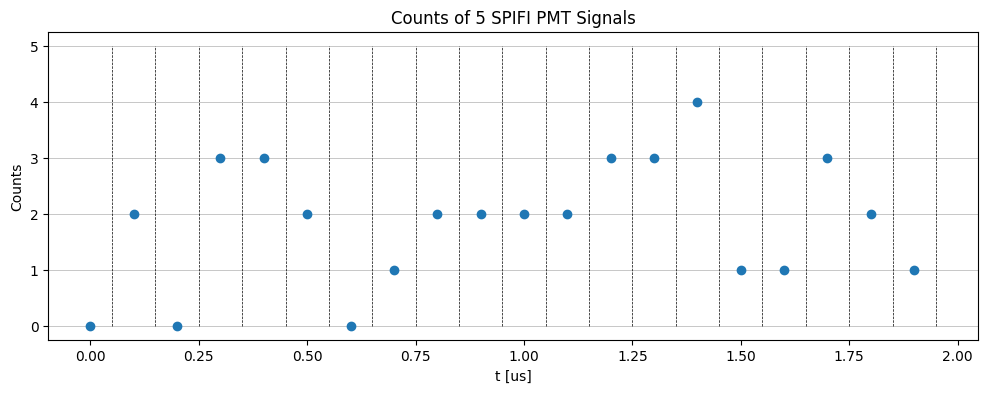

In [49]:
# Perform counting per equivalent time bins through the example signals
countArr = np.zeros(int(focusTime/repTime))
for ii in range(5):
    peaks, _ = find_peaks(np.abs(simulatedSignals[ii][:focusIdx]))
    for jj in range(int(focusTime/repTime)):
        countArr[jj] += np.sum(np.abs(tArr[peaks] - jj*repTime) < repTime/2)

countTime = np.arange(int(focusTime/repTime)) * repTime

plt.figure(figsize=(12,4))
plt.scatter(countTime/us, countArr)
for jj in range(int(focusTime/repTime)):
        plt.vlines(
             (jj*repTime + (repTime/2))/us, -0.0, 5.0, color='k',
             linestyle='--', linewidth=0.5
        )
plt.title("Counts of 5 SPIFI PMT Signals")
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("t [us]")
plt.ylabel("Counts")
# draw horizontal grid lines at the integer ticks, behind the data
plt.grid(axis='y', linestyle='-', linewidth=0.5)
# set the grid lines behind the data
plt.gca().set_axisbelow(True)
plt.show()

### Sparse Signals
To emphasize why photon counting is necessary, the following cell simulates 1000 of these sparse SPIFI PMT signals and averages them. The result is a signal with an overall lower amplitude due to the PMT signal spikes on scans with a detected photon being averaged against multiple zeros when a photon was not detected at that time stamp in other scans. The resulting FFT to produce the SPIFI image is then almost entirely composed of harmonics according to the laser repetition rate of 10 MHz, with no image information apparent.

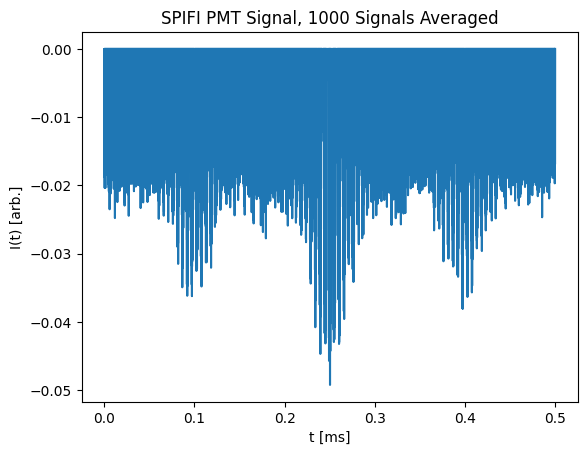

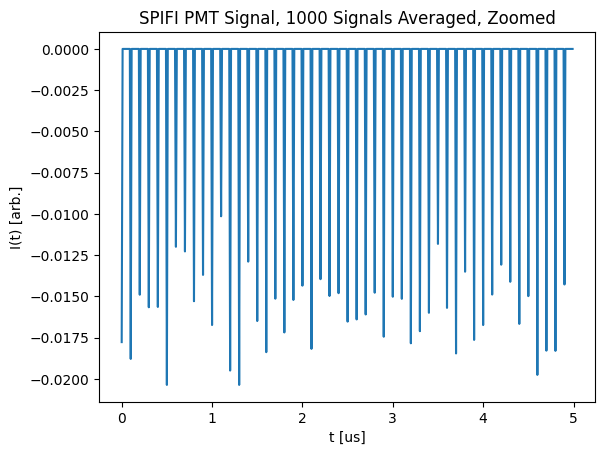

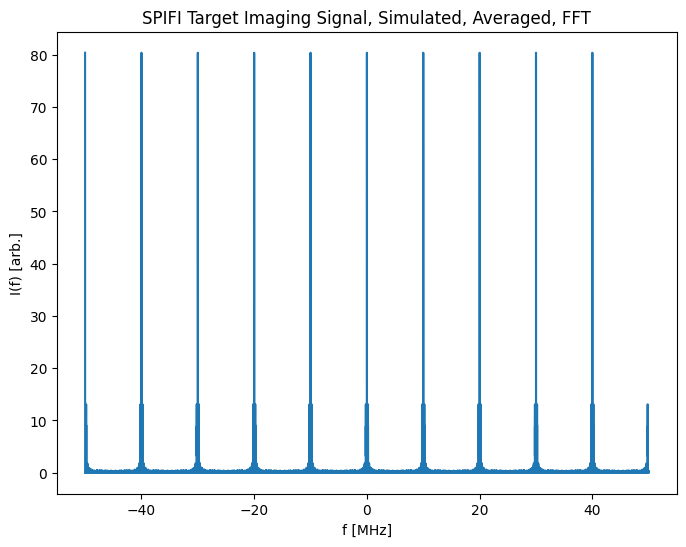

In [50]:
avgExampleNum = 1000
avgExample = np.zeros(MM)
for ii in range(avgExampleNum):
    avgExample += simulate_signal(photonProbabilities, 0.05)

avgExample = avgExample / avgExampleNum

plt.plot(tArr/ms, avgExample)
plt.title("SPIFI PMT Signal, 1000 Signals Averaged")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

# Plot a zoomed in version of the signal
plt.plot(tArr[:500]/us, avgExample[:500])
plt.title("SPIFI PMT Signal, 1000 Signals Averaged, Zoomed")
plt.xlabel("t [us]")
plt.ylabel("I(t) [arb.]")
plt.show()

avgExampleImage = np.abs(fft1(avgExample))
freqArr = np.fft.fftshift(np.fft.fftfreq(MM, dt))

plt.figure(figsize=(8,6))
plt.plot(freqArr/MHz, avgExampleImage)
plt.title("SPIFI Target Imaging Signal, Simulated, Averaged, FFT")
plt.xlabel("f [MHz]")
plt.ylabel("I(f) [arb.]")
plt.show()


Instead, photon counting is needed to make use of many signals. First, a threshold to determine what should count as a detected photon is defined. Any signal spikes that go below this threshold (negative going PMT signal) will result in the counter for that specific time stamp being incremented. This threshold should be set so that minor amplitude variations, which are simulated here, do not exclude valid photons. Another consideration is that the threshold can also exclude low amplitude noise (not simulated here). Another consideration not explicitly shown in this notebook is the use of a window around the excitation pulse to exclude large amplitude signals that do not coincide with the excitation pulse.

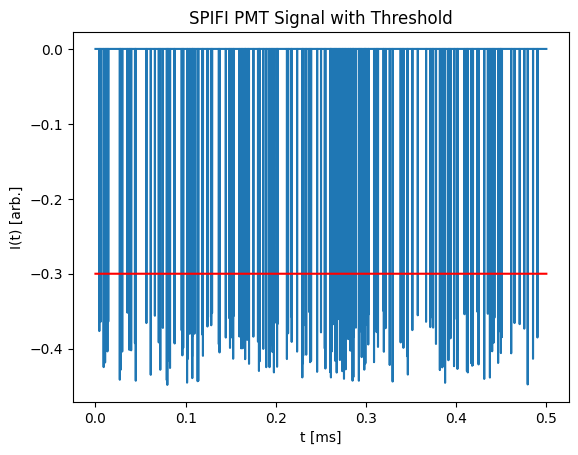

In [51]:
threshold = -0.3

plt.plot(tArr/ms, simulate_signal(photonProbabilities, 0.05))
plt.plot(tArr/ms, threshold*np.ones(MM), color='red')
plt.title("SPIFI PMT Signal with Threshold")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

### Counting from Signals
An array to store the counters for each time bin (at the same interval of the laser repetition rate) is then defined. Because the acquisition frequency was set to 100 MHz and the laser repetition rate is simulated at 10 MHz, there will be 10 times fewer data points in the time binned signal. 

A number of signals to collect for counting is set. This first example uses a low number to generate an initial signal and image quickly.

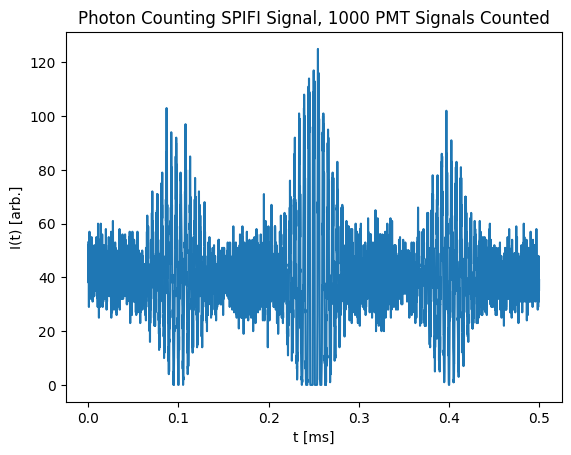

In [52]:
# array for counting at the interval of the rep rate
countArrInterval = int(laserPeriod / dt)
countArr = np.zeros(int(MM / countArrInterval))
countTimeArr = np.arange(0, MM, countArrInterval) * dt
countExampleNum = 1000
# count the number of photons in each interval
for ii in range(countExampleNum):
    nextSignal = simulate_signal(photonProbabilities, 0.05)
    countIdx = 0
    for jj in range(0, MM, countArrInterval):
        if nextSignal[jj] < threshold:
            countArr[countIdx] += 1
        countIdx += 1

plt.plot(countTimeArr/ms, countArr)
plt.title("Photon Counting SPIFI Signal, 1000 PMT Signals Counted")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()


### Photon Counting SPIFI Images
Taking the FFT of this signal made up of 1000 counted signals yields the following, with 1D images being apparent in the SPIFI orders.

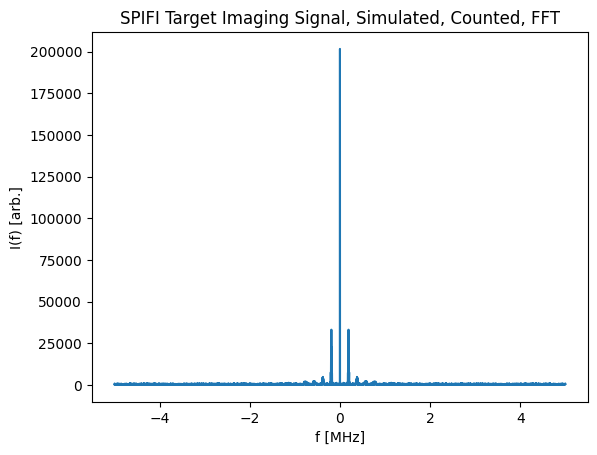

In [53]:
countExampleImg = np.abs(fft1(countArr))
freqArr = np.fft.fftshift(np.fft.fftfreq(len(countArr), dt*countArrInterval))

plt.plot(freqArr/MHz, countExampleImg)
plt.title("SPIFI Target Imaging Signal, Simulated, Counted, FFT")
plt.xlabel("f [MHz]")
plt.ylabel("I(f) [arb.]")
plt.show()

To clearly see the image orders, frequency ranges are set to only plot over a specific range in the first order and the multiples of this range for the enhanced SPIFI orders beyond the first.

The following code block has a helper function to find the indices that focus on a specific frequency range for each image order, and save the references to those slices of the image array for convenience.

A plotting function is then defined to display the 4 SPIFI orders in one figure for comparison.

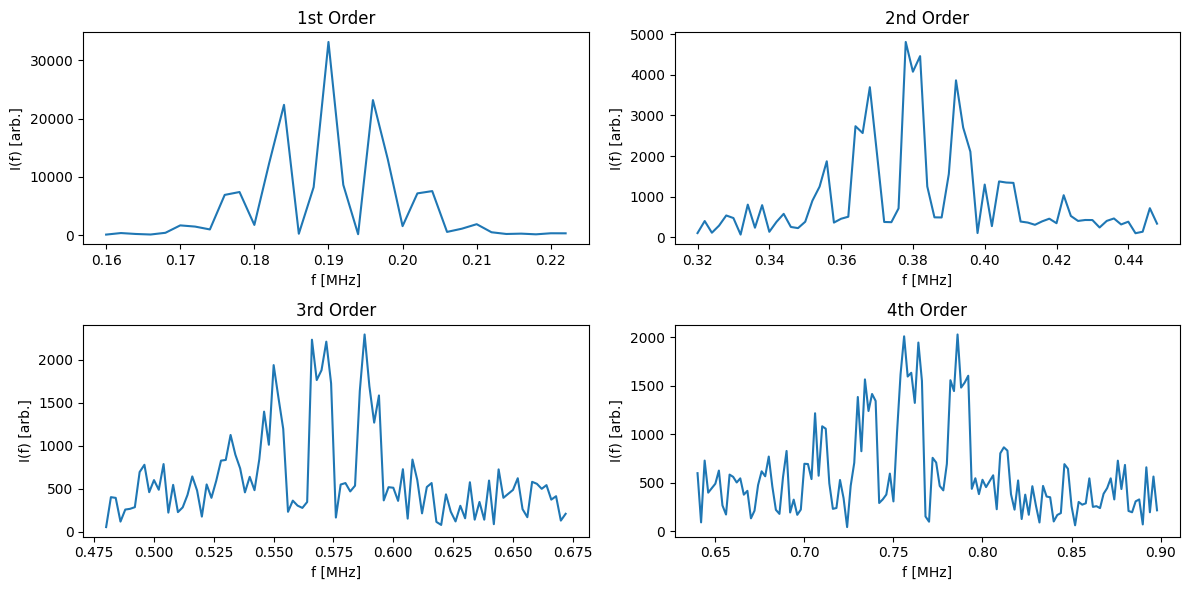

In [54]:
def get_SPIFI_orders(frequencyArr, imgArr, freqRangeArr):
    orderIdxs = [
        find_nearest_idx(frequencyArr, freqRangeArr[0]),
        find_nearest_idx(frequencyArr, freqRangeArr[1])
    ]
    orderFreqArr = frequencyArr[orderIdxs[0]:orderIdxs[1]]
    orderImgArr = imgArr[orderIdxs[0]:orderIdxs[1]]

    return orderFreqArr, orderImgArr

ord1Freqs = np.array([160*kHz, 225*kHz])
ord1FreqArr, ord1Img = get_SPIFI_orders(freqArr, countExampleImg, ord1Freqs)
ord2FreqArr, ord2Img = get_SPIFI_orders(freqArr, countExampleImg, ord1Freqs*2)
ord3FreqArr, ord3Img = get_SPIFI_orders(freqArr, countExampleImg, ord1Freqs*3)
ord4FreqArr, ord4Img = get_SPIFI_orders(freqArr, countExampleImg, ord1Freqs*4)

def plot_SPIFI_orders4(
        freqArrays, imgArrays
    ):
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    axs[0, 0].plot(freqArrays[0]/MHz, imgArrays[0])
    axs[0, 0].set(title='1st Order', xlabel='f [MHz]', ylabel='I(f) [arb.]')
    axs[0, 1].plot(freqArrays[1]/MHz, imgArrays[1])
    axs[0, 1].set(title='2nd Order', xlabel='f [MHz]', ylabel='I(f) [arb.]')
    axs[1, 0].plot(freqArrays[2]/MHz, imgArrays[2])
    axs[1, 0].set(title='3rd Order', xlabel='f [MHz]', ylabel='I(f) [arb.]')
    axs[1, 1].plot(freqArrays[3]/MHz, imgArrays[3])
    axs[1, 1].set(title='4th Order', xlabel='f [MHz]', ylabel='I(f) [arb.]')
    plt.tight_layout()
    plt.show()

plot_SPIFI_orders4(
    [ord1FreqArr, ord2FreqArr, ord3FreqArr, ord4FreqArr],
    [ord1Img, ord2Img, ord3Img, ord4Img]
)

### Longer Exposures, More Counts, Better Dynamic Range
The images of the spatial frequency target begin to take shape. Padding the counted signal with zeros is often done to increase the number of data points in each order of the FFT images. However here we see that past the 2nd order the images are very noisy, much like is seen with integrated PMT signals as done previously.

With the photon counting working, a longer exposure with more signals to count photons over is used (50,000 signals) to produce a signal with a greater dynamic range - meaning greater modulation contrast and a better FFT image.

Long example number: 10000
Long example number: 20000
Long example number: 30000
Long example number: 40000


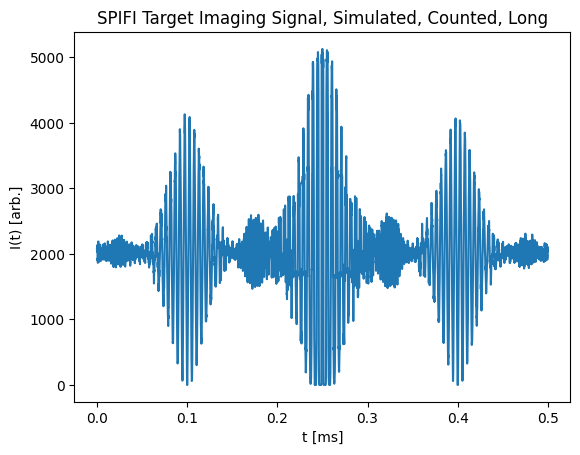

In [55]:
# array for counting at the interval of the rep rate
countLongArr = np.zeros(int(MM / countArrInterval))
countLongExampleNum = 50000

logInterval = 10000
# count the number of photons in each interval
for ii in range(countLongExampleNum):
    nextSignal = simulate_signal(photonProbabilities, 0.05)
    countIdx = 0
    for jj in range(0, MM, countArrInterval):
        if nextSignal[jj] < threshold:
            countLongArr[countIdx] += 1
        countIdx += 1
    if ii % logInterval == 0 and ii > 0:
        print("Long example number: {}".format(ii))

plt.plot(countTimeArr/ms, countLongArr)
plt.title("SPIFI Target Imaging Signal, Simulated, Counted, Long")
plt.xlabel("t [ms]")
plt.ylabel("I(t) [arb.]")
plt.show()

This signal has many more counts overall and a greater dynamic range. The FFT as a whole already appears to have better contrast in the orders.

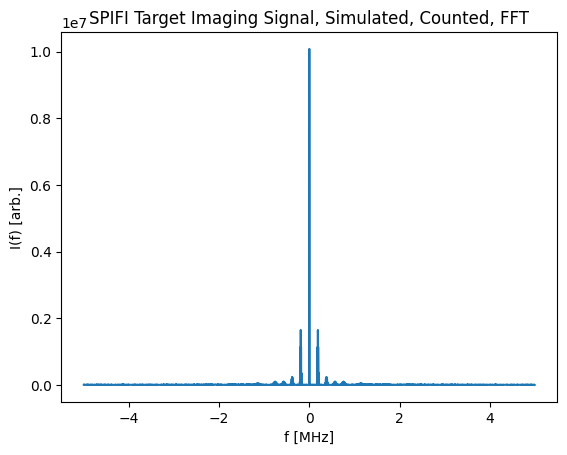

In [56]:
countLongExampleImg = np.abs(fft1(countLongArr))

plt.plot(freqArr/MHz, countLongExampleImg)
plt.title("SPIFI Target Imaging Signal, Simulated, Counted, FFT")
plt.xlabel("f [MHz]")
plt.ylabel("I(f) [arb.]")
plt.show()

Zooming in on the orders then reveals the contrast enhancement and improvement in SNR for every SPIFI order, making the 4th order image viable.

Because the frequency ranges for each SPIFI order have already been calculated and stored, they are not stored again here. The underscore `_` as a variable name indicates that the corresponding data returned from the `get_SPIFI_orders` function is not kept or reassigned to the pre-existing arrays.

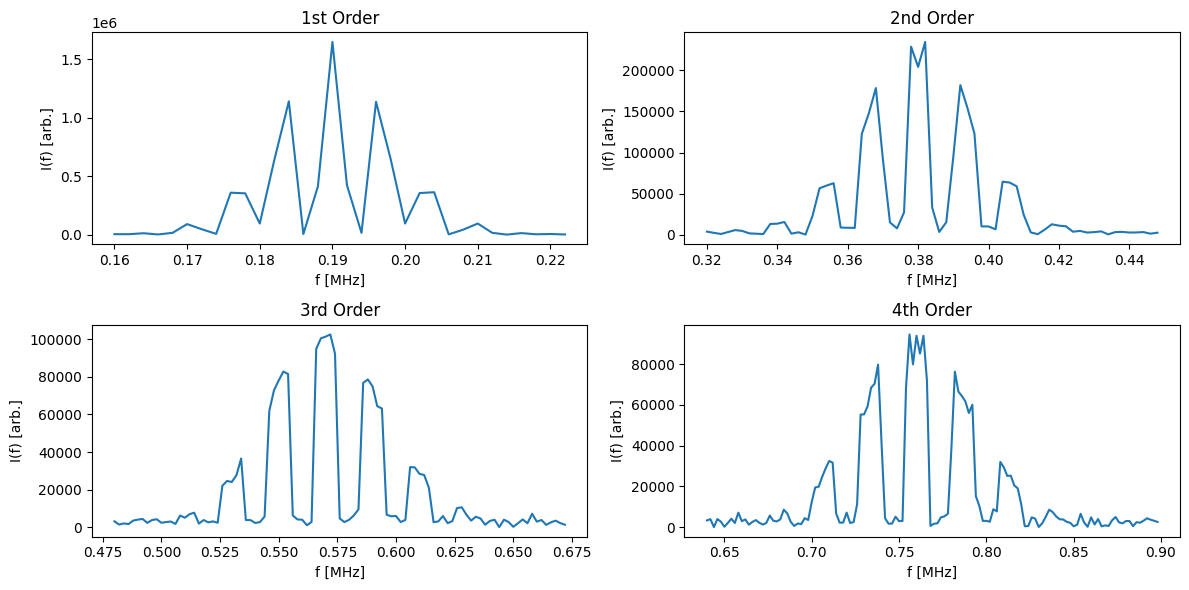

In [57]:
_, ord1ImgLong = get_SPIFI_orders(freqArr, countLongExampleImg, ord1Freqs)
_, ord2ImgLong = get_SPIFI_orders(freqArr, countLongExampleImg, ord1Freqs*2)
_, ord3ImgLong = get_SPIFI_orders(freqArr, countLongExampleImg, ord1Freqs*3)
_, ord4ImgLong = get_SPIFI_orders(freqArr, countLongExampleImg, ord1Freqs*4)

plot_SPIFI_orders4(
    [ord1FreqArr, ord2FreqArr, ord3FreqArr, ord4FreqArr],
    [ord1ImgLong, ord2ImgLong, ord3ImgLong, ord4ImgLong]
)

Note that this simulation focuses on the principles of photon counting with SPIFI, and does not simulate the resolution limits that demonstrate the enhancement in the 2nd and beyond SPIFI orders.